Clustering and classification for features extracted from tiles modified with StainNet.

---
# 0. - Imports and paths

In [32]:
import os
import pandas as pd
import matplotlib.font_manager as fm
%matplotlib inline
import matplotlib.pyplot as plt
import pickle
import matplotlib.image as mpimg
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
import seaborn as sns
from PIL import Image, ImageDraw
import numpy as np
import re
from collections import defaultdict
import matplotlib.pyplot as plt
from sklearn.cluster import FeatureAgglomeration
from sklearn.decomposition import PCA#, TruncatedSVD
#import umap
import umap.umap_ as umap
from sklearn.manifold import TSNE
from matplotlib.lines import Line2D

In [33]:
os.chdir("/disk2/user/gabgam/work/gigi_env/the_project/4_clustering_and_classification/")
print(os.getcwd())

/disk2/work/gabgam/gigi_env/the_project/4_clustering_and_classification


In [34]:
# Fetch DM Sans font file from https://github.com/google/fonts/blob/main/ofl/dmsans/DMSans%5Bopsz%2Cwght%5D.ttf or, better, https://fonts.google.com/specimen/DM+Sans
font_path = "../fonts/static/DMSans-Medium.ttf" 

# Add font to matplotlib
try:
    fm.fontManager.addfont(font_path)
    plt.rcParams['font.family'] = 'DM Sans'
except RuntimeError as e:
    print(f"Failed to load font: {e}")

In [35]:
model = "UNI2-h"

In [36]:
PATH_TO_MERGED_PICKLES = f"output/{model}/satac_C1_v3_allspots_&_visium_2022_FF_WG_10X_img_not_changed_allspots/"
COMPARISON = "satac_C1_v3_allspots_&_visium_2022_FF_WG_10X_img_not_changed_allspots"

SELECTED_PICKLE_100um = 'MERGED_satac_C1_&_v3_allspots__&__visium_2022_FF_WG_10X_&_img_not_changed_allspots__for__target_is_reference_full_100um_histomicsTK_macenko_nomasking.pickle'
SELECTED_PICKLE_68um = 'MERGED_satac_C1_&_v3_allspots__&__visium_2022_FF_WG_10X_&_img_not_changed_allspots__for__target_is_reference_full_68um_histomicsTK_macenko_nomasking.pickle'

In [37]:
# PATH_TO_MERGED_PICKLES = f"output/{model}/satac_C1_v3_allspots_&_visium_FFPE_dcis_idc_10X_img_not_changed_allspots/"
# COMPARISON = "satac_C1_v3_allspots_&_visium_FFPE_dcis_idc_10X_img_not_changed_allspots"

# SELECTED_PICKLE_100um = 'MERGED_satac_C1_&_v3_allspots__&__visium_FFPE_dcis_idc_10X_&_img_not_changed_allspots__for__target_is_reference_full_100um_histomicsTK_macenko_nomasking.pickle'
# SELECTED_PICKLE_68um = 'MERGED_satac_C1_&_v3_allspots__&__visium_FFPE_dcis_idc_10X_&_img_not_changed_allspots__for__target_is_reference_full_68um_histomicsTK_macenko_nomasking.pickle'

In [38]:
# path to the target image
PATH_TO_REFERENCE = "../2_image_normalisation/reference_images/reference_full.jpeg"
# `TARGET_IS_<filename>`
TARGET_IS = "target_is_reference_full"

Defining the path to the figures.

In [39]:
PATH_TO_FIGURES = f"figures/{model}/{COMPARISON}"
os.makedirs(PATH_TO_FIGURES, exist_ok=True)

# 1. - Importing the extracted features

First of all, let's see all the MERGED `.pickle` files inside the folder of the saved features.

In [40]:
all_pickle_names = [i for i in os.listdir(PATH_TO_MERGED_PICKLES) if i.endswith('.pickle')]

print(f"{len(all_pickle_names)} .pickle files inside the folder.\n")
print(all_pickle_names)

8 .pickle files inside the folder.

['MERGED_satac_C1_&_v3_allspots__&__visium_2022_FF_WG_10X_&_img_not_changed_allspots__for__target_is_reference_full_100um_ORIGINAL WSI.pickle', 'MERGED_satac_C1_&_v3_allspots__&__visium_2022_FF_WG_10X_&_img_not_changed_allspots__for__target_is_reference_full_100um_fromWSI_histomicsTK_macenko_nomasking.pickle', 'MERGED_satac_C1_&_v3_allspots__&__visium_2022_FF_WG_10X_&_img_not_changed_allspots__for__target_is_reference_full_100um_histomicsTK_macenko_nomasking.pickle', 'MERGED_satac_C1_&_v3_allspots__&__visium_2022_FF_WG_10X_&_img_not_changed_allspots__for__target_is_reference_full_100um_stainNET.pickle', 'MERGED_satac_C1_&_v3_allspots__&__visium_2022_FF_WG_10X_&_img_not_changed_allspots__for__target_is_reference_full_68um_ORIGINAL WSI.pickle', 'MERGED_satac_C1_&_v3_allspots__&__visium_2022_FF_WG_10X_&_img_not_changed_allspots__for__target_is_reference_full_68um_fromWSI_histomicsTK_macenko_nomasking.pickle', 'MERGED_satac_C1_&_v3_allspots__&__visium_20

And let's choose the first file to visualise and extract the normalisation name from it.

In [41]:
TILE_SIZE = 100
SPOT_SIZE = 68

# Extractin the normalisation name from just one of it. They are the same in the end
# Find the pattern matching "<number>um_", the normalisation name is after it.
match = re.search(r"\d+um_", SELECTED_PICKLE_100um)

if match:
    # Extract everything after "<number>um_", remove the file type name and replace eventually present underscores with spaces.
    normalisation_name = SELECTED_PICKLE_100um.split(match.group())[-1].split(".")[0].replace("_", " ")
else:
    print("Wrong file inserted, no normalisation name found.")

print(normalisation_name)

histomicsTK macenko nomasking


In [42]:
from utils_clust_n_class import load_pickle_as_df

merged_selected_pickle_df_100um = load_pickle_as_df(os.path.join(PATH_TO_MERGED_PICKLES, SELECTED_PICKLE_100um))
merged_selected_pickle_df_100um

,0,1,2,3,4,5,6,7,8,9,...,1526,1527,1528,1529,1530,1531,1532,1533,1534,1535
TTATTTCCAGTATCTT_row6_col18_100um_histomicsTK_macenko_nomasking.jpg,0.124812,0.456939,0.355705,-0.028777,0.003545,-0.443926,-0.080795,-0.642182,-0.052208,0.423757,...,-0.175149,0.152521,0.163608,-0.022184,0.296276,0.238105,-0.247685,-0.252992,-0.248712,-0.252929
TCAAATCACCATTGTT_row7_col19_100um_histomicsTK_macenko_nomasking.jpg,0.254652,0.281422,-0.282730,0.020829,0.009576,-0.282667,0.048078,-0.593783,0.026106,0.078278,...,-0.589326,-0.481810,0.143336,-0.054886,0.011864,-0.162836,-0.465747,-0.694996,-0.105858,0.313824
CTGTAAGTCTTCTGCT_row6_col20_100um_histomicsTK_macenko_nomasking.jpg,-0.011986,0.514269,-0.151397,-0.086166,0.137472,-0.204235,-0.251268,-0.795368,-0.009784,0.421897,...,-0.822431,-0.554079,0.251086,0.168949,-0.190393,0.310827,-0.336821,0.001698,-0.007421,-0.000496
ACATCCGACTTTGGGT_row7_col21_100um_histomicsTK_macenko_nomasking.jpg,0.331965,0.732342,-0.005193,0.018344,-0.102333,-0.537718,0.242630,-0.790101,0.402539,0.510331,...,-0.524612,-0.569052,0.588254,0.412273,0.105432,-0.246798,-0.372021,-0.593591,-0.179750,0.121884
TGATAGATGCCCTGTT_row6_col22_100um_histomicsTK_macenko_nomasking.jpg,-0.294759,0.029385,0.155710,-0.243489,0.130776,-0.079380,-0.485525,-0.663607,-0.209514,0.532067,...,-0.595709,0.154860,0.405706,0.289553,-0.004244,0.185217,0.180560,-0.106937,0.022607,0.272779
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
GAACGTTTGTATCCAC-1_row77_col123_100um_histomicsTK_macenko_nomasking.jpg,-0.239360,-0.085375,-0.276265,-0.307827,-0.100266,0.036856,0.268526,-0.030581,-0.337120,0.089333,...,-0.209175,-0.154883,-0.374371,0.184657,0.431706,0.063817,0.222409,-0.109330,-0.184033,-0.305559
ATTGAATTCCCTGTAG-1_row76_col124_100um_histomicsTK_macenko_nomasking.jpg,-0.438314,-0.272793,-0.017341,-0.425316,-0.223330,0.030377,-0.190246,0.137443,-0.194983,0.449609,...,-0.422201,0.088044,-0.179914,0.092159,0.238051,0.123042,0.342219,-0.015705,-0.280380,-0.130569
TACCTCACCAATTGTA-1_row77_col125_100um_histomicsTK_macenko_nomasking.jpg,0.310214,-0.128880,-0.249115,-0.363930,-0.112475,0.181084,0.094203,-0.220672,-0.307405,0.415425,...,-0.540299,-0.222807,-0.284332,0.258300,0.165836,-0.179153,0.346365,-0.087938,-0.101484,-0.051292
AGTCGAATTAGCGTAA-1_row76_col126_100um_histomicsTK_macenko_nomasking.jpg,-0.074272,-0.433240,-0.472722,-0.468590,-0.047517,0.273412,0.089674,0.302975,-0.079056,0.457233,...,-0.446687,0.092758,-0.058073,-0.102932,0.074870,-0.282334,0.412737,-0.185296,-0.330025,0.084076


In [43]:
from utils_clust_n_class import load_pickle_as_df

merged_selected_pickle_df_68um = load_pickle_as_df(os.path.join(PATH_TO_MERGED_PICKLES, SELECTED_PICKLE_68um))
merged_selected_pickle_df_68um

,0,1,2,3,4,5,6,7,8,9,...,1526,1527,1528,1529,1530,1531,1532,1533,1534,1535
CCGACCACCCTACGCG_row0_col0_68um_histomicsTK_macenko_nomasking.jpg,0.231082,-0.000807,-0.115975,-0.102181,0.218956,-0.134048,0.191508,-0.812966,0.297080,0.237753,...,-0.183785,-0.402442,-0.029682,-0.346236,0.013579,0.101487,-0.392896,-0.502757,0.070022,0.485976
AAGCCATAGTCGCGAC_row1_col1_68um_histomicsTK_macenko_nomasking.jpg,-0.100091,0.244098,-0.063580,-0.015096,0.075824,-0.298687,-0.105391,-0.485860,0.087259,0.430128,...,-0.347054,-0.115743,-0.238577,0.093472,0.027230,0.052773,-0.411942,-0.400563,-0.253814,0.072173
TTGGGCGGACCGAAGC_row0_col2_68um_histomicsTK_macenko_nomasking.jpg,-0.009002,0.327672,-0.157133,-0.020838,0.055272,-0.546852,-0.055894,-0.534804,0.257114,0.336024,...,-0.227530,-0.358827,0.096895,-0.259203,0.067773,0.164373,-0.745350,-0.504894,-0.006941,0.290454
AGTAAAGCGCATAATC_row1_col3_68um_histomicsTK_macenko_nomasking.jpg,0.105967,0.171182,0.277252,-0.101250,0.065381,-0.005889,-0.056769,-0.698137,0.241743,0.195445,...,-0.447100,-0.521371,0.678048,-0.042841,0.153587,-0.087965,-0.506997,-0.796459,-0.282675,0.026572
CGACTCCGCCGATCAA_row0_col4_68um_histomicsTK_macenko_nomasking.jpg,0.003994,-0.228704,-0.001277,-0.076260,0.086139,-0.314674,-0.077091,-0.503361,0.096658,0.541754,...,-0.226925,-0.101395,0.157453,-0.490854,0.055652,0.306610,-0.514799,-0.372846,0.017713,0.286025
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
GAACGTTTGTATCCAC-1_row77_col123_68um_histomicsTK_macenko_nomasking.jpg,-0.133799,0.002165,-0.046325,-0.260299,-0.089471,0.537977,0.331185,-0.333182,-0.441195,0.165890,...,-0.565600,0.117148,-0.455262,0.134334,0.425124,-0.022367,0.333482,0.351928,-0.037596,-0.066711
ATTGAATTCCCTGTAG-1_row76_col124_68um_histomicsTK_macenko_nomasking.jpg,0.137228,-0.018093,0.053780,-0.302722,-0.228353,0.309641,0.131953,-0.094733,-0.361780,-0.013016,...,-0.059171,0.163159,0.021831,0.408173,-0.092569,-0.062143,0.336730,-0.066342,-0.308147,-0.091009
TACCTCACCAATTGTA-1_row77_col125_68um_histomicsTK_macenko_nomasking.jpg,0.020423,0.185950,-0.182079,-0.368792,-0.174693,0.063230,0.167783,-0.130470,0.013388,0.507437,...,-0.460070,0.271483,-0.069067,-0.012664,0.086282,0.199481,0.292597,-0.213758,-0.075924,-0.252125
AGTCGAATTAGCGTAA-1_row76_col126_68um_histomicsTK_macenko_nomasking.jpg,-0.024564,0.064335,-0.320449,-0.253957,-0.065699,0.207479,-0.029078,-0.070886,-0.022631,-0.108048,...,-0.189079,-0.104666,0.046133,-0.134130,0.211668,-0.283365,0.365241,-0.074674,-0.144594,0.196428


# 2. - Dimensionality reduction

Let's plot the cumulative variance explained by the most important components.

## 2.1 - For 100 μm tiles

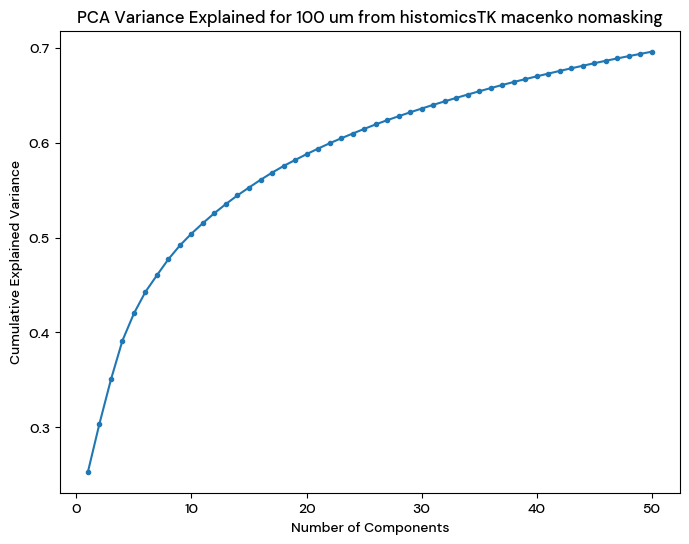

In [44]:
from utils_clust_n_class import pca_cumulative_variance_plot

plot = pca_cumulative_variance_plot(merged_selected_pickle_df_100um, normalisation_name, TILE_SIZE)
plot.show()

Then let's have a quick visualisation of the PCA, UMAP and tSNE plots.

/disk2/work/gabgam/gigi_env/the_project/4_clustering_and_classification/utils_clust_n_class.py:159: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(result[:, 0], result[:, 1], c=colors, s=4, cmap='coolwarm')
/disk2/work/gabgam/gigi_env/the_project/4_clustering_and_classification/utils_clust_n_class.py:159: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(result[:, 0], result[:, 1], c=colors, s=4, cmap='coolwarm')
/disk2/work/gabgam/gigi_env/the_project/4_clustering_and_classification/utils_clust_n_class.py:159: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(result[:, 0], result[:, 1], c=colors, s=4, cmap='coolwarm')


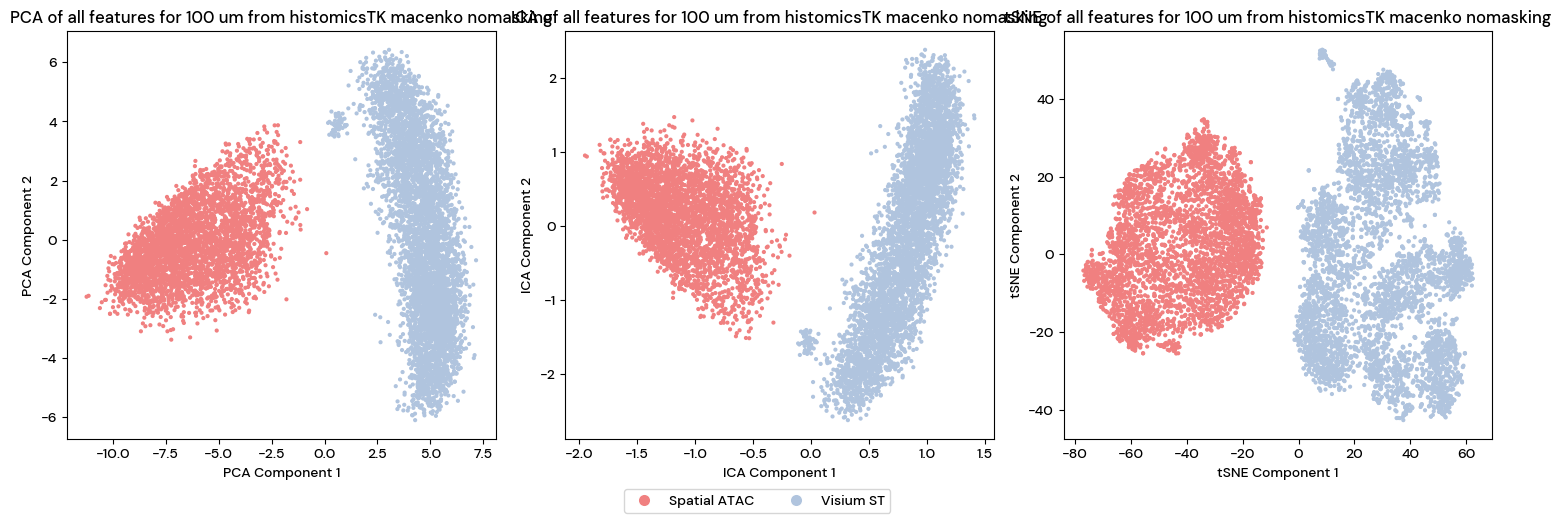

In [45]:
from utils_clust_n_class import all_dim_red

COLORS_FOR_SPATIALS = {"Spatial ATAC": "lightcoral", "Visium ST": "lightsteelblue"}

plot_100, dim_red_results_100 =  all_dim_red(merged_selected_pickle_df_100um, normalisation_name, COLORS_FOR_SPATIALS, TILE_SIZE, selected_methods = ["PCA", "ICA", "tSNE"])
plot_100.show()

In [46]:
plot_100.savefig(os.path.join(PATH_TO_FIGURES, f"plot_all_dimensionality_reductions_{TILE_SIZE}um_{normalisation_name.replace(' ', '_')}.pdf"),
                format="PDF", bbox_inches='tight')

So, we can say that the normalisation is necessary.

---

## 2.2 - For 68 μm tiles

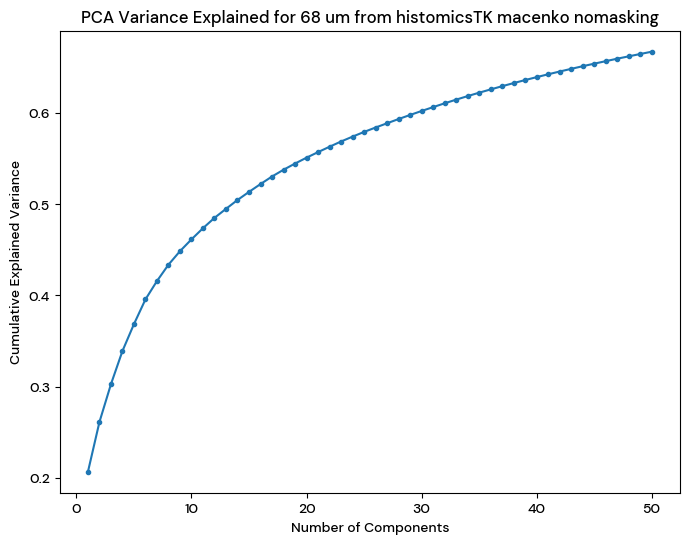

In [47]:
from utils_clust_n_class import pca_cumulative_variance_plot

plot = pca_cumulative_variance_plot(merged_selected_pickle_df_68um, normalisation_name, SPOT_SIZE)
plot.show()

Then let's have a quick visualisation of the PCA, UMAP and tSNE plots.

/disk2/work/gabgam/gigi_env/the_project/4_clustering_and_classification/utils_clust_n_class.py:159: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(result[:, 0], result[:, 1], c=colors, s=4, cmap='coolwarm')
/disk2/work/gabgam/gigi_env/the_project/4_clustering_and_classification/utils_clust_n_class.py:159: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(result[:, 0], result[:, 1], c=colors, s=4, cmap='coolwarm')
/disk2/work/gabgam/gigi_env/the_project/4_clustering_and_classification/utils_clust_n_class.py:159: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(result[:, 0], result[:, 1], c=colors, s=4, cmap='coolwarm')


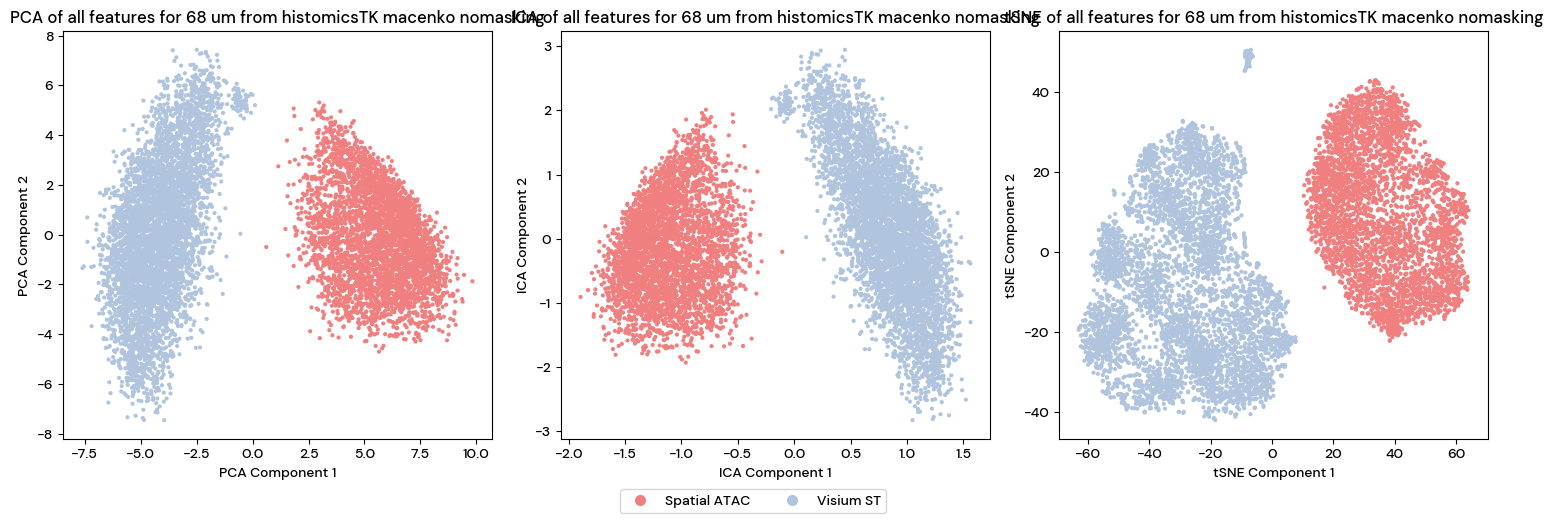

In [48]:
from utils_clust_n_class import all_dim_red

COLORS_FOR_SPATIALS = {"Spatial ATAC": "lightcoral", "Visium ST": "lightsteelblue"}

plot_68, dim_red_results_68 =  all_dim_red(merged_selected_pickle_df_68um, normalisation_name, COLORS_FOR_SPATIALS, SPOT_SIZE, selected_methods = ["PCA", "ICA", "tSNE"])
plot_68.show()

In [49]:
plot_68.savefig(os.path.join(PATH_TO_FIGURES, f"plot_all_dimensionality_reductions_{SPOT_SIZE}um_{normalisation_name.replace(' ', '_')}.pdf"), 
                format="PDF", bbox_inches='tight')

So, we can say that the normalisation is necessary.

---

## 3.2 Spectral Clustering

When we talk about “affinity”, we are essentially referring to how similar two points are to each other. In practical terms, affinity determines how close or similar points are in a multidimensional space. The more similar two points are, the greater the value of the affinity between them, and vice versa.

In the context of spectral clustering, there are several methods to calculate affinity. Some of the main methods are:

-   **Nearest Neighbors**: The affinity between points is calculated based on the Euclidean distance or a distance metric defined between the closest points.
-   **RBF (Radial Basis Function)**: Affinity is calculated using a Gaussian radial function, which measures the distance between points in feature space.
-   **Precomputed**: Allows you to provide a precomputed similarity or dissimilarity matrix between points.
-   **KNN (K-Nearest Neighbors)**: Uses the similarity between the k-nearest points as affinity.


# 4. Clustering

In [45]:
import math
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering, HDBSCAN, MeanShift, estimate_bandwidth, SpectralClustering, AffinityPropagation, Birch
from sklearn.mixture import GaussianMixture


clustering_methods = [
    ("K-Means", KMeans(n_clusters=5, random_state=123)),
    ("Spectral Clustering", SpectralClustering(n_clusters=5, affinity='nearest_neighbors', n_neighbors=10, 
                                               eigen_solver='arpack', random_state=123)),
    ("MeanShift", MeanShift()),  # bandwidth will be estimated later
    ("DBSCAN", DBSCAN(eps=0.5, min_samples=20)),
    ("HDBSCAN", HDBSCAN(min_cluster_size=20)),
    ("Agglomerative", AgglomerativeClustering(n_clusters=5, metric='euclidean', linkage='ward')),
    ("Affinity Propagation", AffinityPropagation(preference=-50)),  # Adjust preference as needed
    ("Birch", Birch(threshold=0.5, n_clusters=5)),  # Adjust threshold as needed
    ("Gaussian Mixture", GaussianMixture(n_components=5, random_state=123))
]

n_methods = len(clustering_methods)
rows = 2
cols = math.ceil(n_methods / rows)

for tech in dim_red_results.keys():
    fig, axes = plt.subplots(rows, cols, figsize=(cols * 5, rows * 5), constrained_layout=True)
    
    for i, (method_name, model) in enumerate(clustering_methods):
        # Estimate bandwidth if using MeanShift
        if method_name == "MeanShift":
            est_band = estimate_bandwidth(dim_red_results[tech])
            model.set_params(bandwidth=est_band)
        
        

        # Compute row and col indices
        row, col = divmod(i, cols)
        
        # Fit the clustering model and predict labels
        cluster_labels = model.fit_predict(dim_red_results[tech])
        
        # Plot in the appropriate subplot
        ax = axes[row, col]  # Access subplot by row and column
        scatter = ax.scatter(dim_red_results[tech][:, 0], dim_red_results[tech][:, 1], c=cluster_labels, s=5, cmap='tab10')
        ax.set_title(f"{tech} Projection with {method_name} Clustering")
        ax.set_xlabel(f'{method_name} Component 1')
        ax.set_ylabel(f'{method_name} Component 2')
    
    plt.tight_layout()
    plt.show()


NameError: name 'dim_red_results' is not defined

In [ ]:
from sklearn.cluster import SpectralClustering
from sklearn.datasets import make_blobs

# Generate sample data
X, _ = make_blobs(n_samples=100, centers=3, cluster_std=0.60, random_state=0)

# Apply Spectral Clustering
sc = SpectralClustering(n_clusters=3, affinity='nearest_neighbors', n_init=100)
labels = sc.fit_predict(X)

print("Cluster labels:", labels)